## DML-Project
Object detection and classification of strawberry ripeness

### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.io import read_image 
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import draw_bounding_boxes 
from itertools import chain
from PIL import Image
from pathlib import Path
import os
import matplotlib.patches as patches

### Image folders

In [3]:
train_data = "./images/train"
val_data   = "./images/valid"
test_data  = "./images/test"

### Load datasets and apply transformations

Mosaic augmentation,
flips and rotations,
resize,
zoom in,
crop

In [4]:
class StrawberryData(Dataset):
    
    def __init__(self, root, transform, ripe_label=0, unripe_label=1):
        """Constructor
        
        Args:
            root (Path/str): Filepath to the data root, e.g. './small_train'
            transform (Compose): A composition of image transforms, see below.
        """
            
        self.root = Path(root)
        self.transform = transform
        self._ripe_label = ripe_label
        self._unripe_label = unripe_label
        
        self.image_paths = [os.path.join(root, 'images', img_name) for img_name in os.listdir(os.path.join(root, 'images'))]
        self.label_paths = [os.path.join(root, 'labels', label_name) for label_name in os.listdir(os.path.join(root, 'labels'))]
        
        self.image_paths.sort()
        self.label_paths.sort()
        
        self._samples = self._collect_samples()
    
    def _collect_samples(self):
        """Collect all paths and labels
        
        Helper method for the constructor
        """

        strawberry_paths_and_labels = map(lambda path: (self.__getitem__(path)), self.image_paths)
        return strawberry_paths_and_labels
        
        #strawberry_paths_and_labels = map(lambda path: (path, self._dog_label), strawberry_paths)
        #return sorted(list(strawberry_paths_and_labels), key=lambda x: x[0].stem)
     
    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory
        
        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(f"Data root '{self.root}' must contain sub dir '{sub_dir.name}'")
        return sub_dir.glob("*.jpg")

    @staticmethod
    def _collect_labels_sub_dir(sub_dir: Path):
        """Collect image paths in a directory
        
        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(f"Data root '{self.root}' must contain sub dir '{sub_dir.name}'")
        return sub_dir.glob("*.txt")
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = Image.open(image_path)

        with open(label_path, 'r') as f:
            annotations = f.readlines()
            annotations = list(map(lambda x: x.replace("\n", "").split(" "), annotations))

        if self.transform:
            image = self.transform(image)

        return image, annotations

    def __len__(self):
        return len(self.image_paths)

In [5]:
transform = Compose([ToTensor()])

train_dataset = StrawberryData(train_data, transform)
val_dataset   = StrawberryData(val_data, transform)
test_dataset  = StrawberryData(test_data, transform)

### Example image from the dataset

['1', '0.09375', '0.34765625', '0.134765625', '0.169921875']


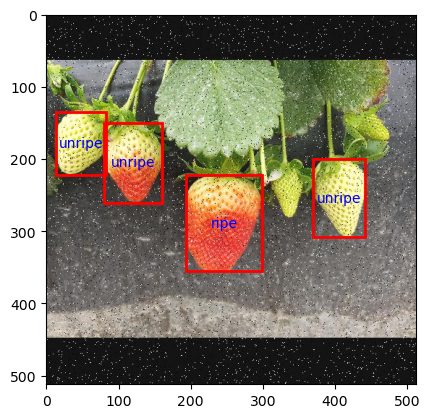

In [6]:
def display_image(axis, image_tensor, label):
    print(label[0])
    
    classification = {
        '0': 'ripe',
        '1': 'unripe'
    }

    image_data = image_tensor.permute(1, 2, 0).numpy()
    height, width, _ = image_data.shape
    axis.imshow(image_data)
    axis.set_xlim(0, width)
    axis.set_ylim(height, 0)
    for l in label:
            [lab, x1, y1, x2, y2] = l
            x1, y1, x2, y2 = float(x1), float(y1), float(x2), float(y2)
            rect = patches.Rectangle(((x1-(x2/2))*width, (y1-(y2/2))*height), x2*width, y2*height, linewidth=2, edgecolor='r', facecolor='none', label="asd")
            axis.add_patch(rect)
            text = axis.text(x1*width, y1*height, classification[lab], color="blue", ha="center", va="center")
    plt.show()

_, axis = plt.subplots()
image_tensor, label = train_dataset[35]
display_image(axis, image_tensor, label)

### Dataloaders

In [7]:
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_data_loader   = DataLoader(val_dataset, batch_size=val_dataset.__len__())
test_data_loader  = DataLoader(test_dataset, batch_size=test_dataset.__len__())

### YOLOv5

Using cache found in /Users/lucaskarlsson/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 ðŸš€ 2023-10-10 Python-3.9.16 torch-1.11.0.post2 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
image 1/1: 512x512 1 broccoli
Speed: 10.7ms pre-process, 273.4ms inference, 11.3ms NMS per image at shape (1, 3, 640, 640)


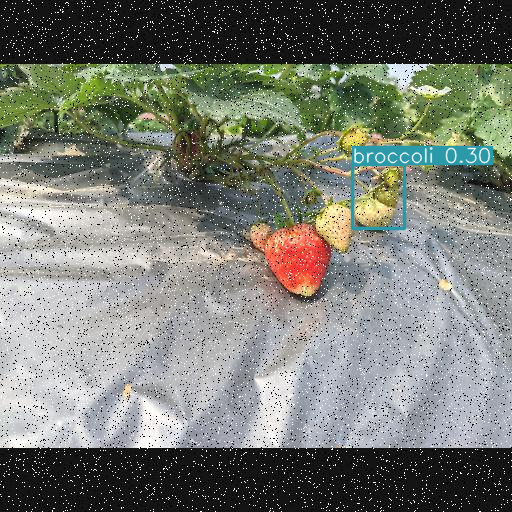

In [12]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
imgs = ['./images/train/images/00461_png.rf.e9be68845aeebdf3a70eb0157b211fda.jpg']  # batch of images

results = model(imgs)

results.print()
results.show()

#https://www.kaggle.com/code/espsiyam/yolov5-ensemble-tta-transfer-learning-hpt
#https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/#clearml-logging-and-automation-new
